In [508]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.special import erf
import numpy as np
import pandas as pd

In [509]:
df1 = pd.read_csv('task1.csv')
df1

,xi,ni
0,28-30,1
1,30-32,2
2,32-34,10
3,34-36,54
4,36-38,88
5,38-40,79
6,40-42,45
7,42-44,17
8,44-46,3
9,46-48,1


In [510]:
def split_interval(x):
    return (float(x.split('-')[0]), float(x.split('-')[1]))

In [511]:
df1.iloc[:, 0] = df1.iloc[:, 0].apply(split_interval)
df1

,xi,ni
0,"(28.0, 30.0)",1
1,"(30.0, 32.0)",2
2,"(32.0, 34.0)",10
3,"(34.0, 36.0)",54
4,"(36.0, 38.0)",88
5,"(38.0, 40.0)",79
6,"(40.0, 42.0)",45
7,"(42.0, 44.0)",17
8,"(44.0, 46.0)",3
9,"(46.0, 48.0)",1


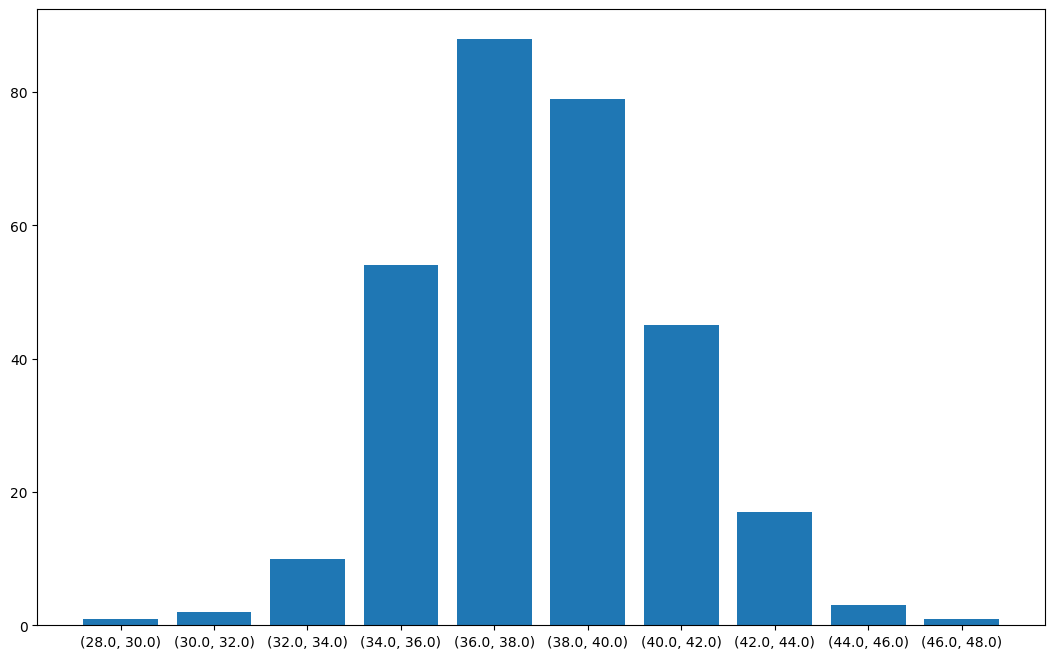

In [512]:
plt.figure(figsize=(13, 8))
plt.bar(df1.iloc[:, 0].astype(str), df1.iloc[:, 1])
plt.show()


In [513]:
def avg_interval(df):
    df['avg_interval'] = df['xi'].apply(lambda x: (x[1] + x[0]) / 2)
    return df

df1 = avg_interval(df1)
df1

,xi,ni,avg_interval
0,"(28.0, 30.0)",1,29.0
1,"(30.0, 32.0)",2,31.0
2,"(32.0, 34.0)",10,33.0
3,"(34.0, 36.0)",54,35.0
4,"(36.0, 38.0)",88,37.0
5,"(38.0, 40.0)",79,39.0
6,"(40.0, 42.0)",45,41.0
7,"(42.0, 44.0)",17,43.0
8,"(44.0, 46.0)",3,45.0
9,"(46.0, 48.0)",1,47.0


In [514]:

def get_avg(df):
    df_copy = df.copy()
    df_copy['avg'] = df['avg_interval'] * df['ni']
    return df_copy['avg'].sum() / df['ni'].sum()

def get_std(df):
    df_copy = df.copy()
    
    df_copy['dev'] = ((df['avg_interval'] - get_avg(df_copy)) ** 2) * df_copy['ni']
    deviation = df_copy['dev'].sum()

    variance = deviation / (df['ni'].sum() - 1)
    
    return np.sqrt(variance)

In [515]:
import numpy as np

def get_erf(x):
    return erf(x / 2 ** 0.5) / 2

def get_prob(df, x_average, standart):
    min_x = df['xi'][0][0]
    max_x = df['xi'][len(df) - 1][1]
    
    def find_probability(row):
        x = row['xi']
        if x[0] == min_x:
            return get_erf((x[1] - x_average) / standart) - get_erf(-np.inf)
        
        elif x[1] == max_x:
            return get_erf(np.inf) - get_erf((x[0] - x_average) / standart)
        
        else:
            return get_erf((x[1] - x_average) / standart) - get_erf((x[0] - x_average) / standart)
        
    df['pi'] = df.apply(find_probability, axis=1)

    return df

In [516]:
print("Гіпотеза H0 - нормальний закон розподілу")

params = input("Вводити параметри вручну чи оцінити? (0 / 1)")
if(params == '0'):
    average = float(input("Введіть x середнє: "))
    standart = float(input("Введіть стандарт: "))
    d_f = 2
else:
    average = get_avg(df1)
    standart = get_std(df1)
    d_f = 0

alpha = float(input(("Введіть рівень значущості: ")))

df1 = get_prob(df1, average, standart)
df1


Гіпотеза H0 - нормальний закон розподілу


,xi,ni,avg_interval,pi
0,"(28.0, 30.0)",1,29.0,0.001359
1,"(30.0, 32.0)",2,31.0,0.010856
2,"(32.0, 34.0)",10,33.0,0.054245
3,"(34.0, 36.0)",54,35.0,0.158640
4,"(36.0, 38.0)",88,37.0,0.271917
5,"(38.0, 40.0)",79,39.0,0.273371
6,"(40.0, 42.0)",45,41.0,0.161200
7,"(42.0, 44.0)",17,43.0,0.055713
8,"(44.0, 46.0)",3,45.0,0.011270
9,"(46.0, 48.0)",1,47.0,0.001427


In [517]:
df1 = df1.drop('avg_interval', axis=1)

In [518]:
def combine_rows(df):
    is_valid = False
    
    while not is_valid:
        for i in range(df.shape[0]):
            if df.iloc[i]['ni'] < 5 or df.iloc[i]['ni'] * df.iloc[i]['pi'] < 10:
                is_valid = False
                
                if i == 0 or i <= df.shape[0]//2:   
                    res1 = df.iloc[[i, i+1], :]
                    res1['xi'] = ((res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]), (res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]))
                    res1['ni'] = res1['ni'].sum()
                    res1['pi'] = res1['pi'].sum()
                    res1 = res1.drop_duplicates()

                    df = pd.concat([df.drop([i, i+1], axis=0), res1]).reset_index(drop=True)
                    df = df.sort_values(by='xi').reset_index(drop=True)

                    break

                else:
                    res1 = df.iloc[[i-1, i], :]
                    
                    res1['xi'] = ((res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]), (res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]))
                    res1['ni'] = res1['ni'].sum()
                    res1['pi'] = res1['pi'].sum()
                    res1 = res1.drop_duplicates()
                    
                    df = pd.concat([df.drop([i-1, i], axis=0), res1]).reset_index(drop=True)
                    df = df.sort_values(by='xi').reset_index(drop=True)

                    break
            is_valid = True
    return df

In [519]:
df1 = combine_rows(df1)
df1

/var/folders/3j/fx3scy6s59q9k_hmbm9swlhh0000gn/T/ipykernel_78217/1886490026.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res1['xi'] = ((res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]), (res1['xi'].iloc[0][0], res1['xi'].iloc[1][1]))
/var/folders/3j/fx3scy6s59q9k_hmbm9swlhh0000gn/T/ipykernel_78217/1886490026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res1['ni'] = res1['ni'].sum()
/var/folders/3j/fx3scy6s59q9k_hmbm9swlhh0000gn/T/ipykernel_78217/1886490026.py:13: SettingWithCopyWarning: 
A valu

,xi,ni,pi
0,"(28.0, 36.0)",67,0.225101
1,"(36.0, 38.0)",88,0.271917
2,"(38.0, 40.0)",79,0.273371
3,"(40.0, 48.0)",66,0.229612


In [520]:
def get_empirical_x2(df):
    df_t = df.copy()
    df_t['emp'] = (df_t['ni'] - df_t['ni'].sum() * df_t['pi']) ** 2 / (df_t['ni'].sum() * df_t['pi'])
    return df_t['emp'].sum()

def get_critical_x2(alpha, df):
    return chi2.ppf(1 - alpha, df)

In [521]:
x2_emp = get_empirical_x2(df1)
print(f"X2 емпіричне: {x2_emp}")

d_f += df1.shape[0] -1 -2
x2_crit = get_critical_x2(alpha, d_f)
print(f"X2 критичне: {x2_crit}")

if(x2_emp < x2_crit):
    print("Емпіричне < критичне - гіпотезу Н0 приймаємо")
else:
    print("Емпіричне > критичне - гіпотезу Н0 відхиляємо")

X2 емпіричне: 0.7414786515411623
X2 критичне: 3.841458820694124
Емпіричне < критичне - гіпотезу Н0 приймаємо


## Задача 2

In [532]:
df2 = pd.read_csv('task2.csv')
df2.iloc[:, 0] = df2.iloc[:, 0].apply(split_interval)
df2

,xi,ni
0,"(0.0, 1.5)",143
1,"(1.5, 3.0)",138
2,"(3.0, 4.5)",139
3,"(4.5, 6.0)",142
4,"(6.0, 7.5)",143
5,"(7.5, 9.0)",138
6,"(9.0, 10.5)",139
7,"(10.5, 12.0)",143
8,"(12.0, 13.5)",142
9,"(13.5, 15.0)",140


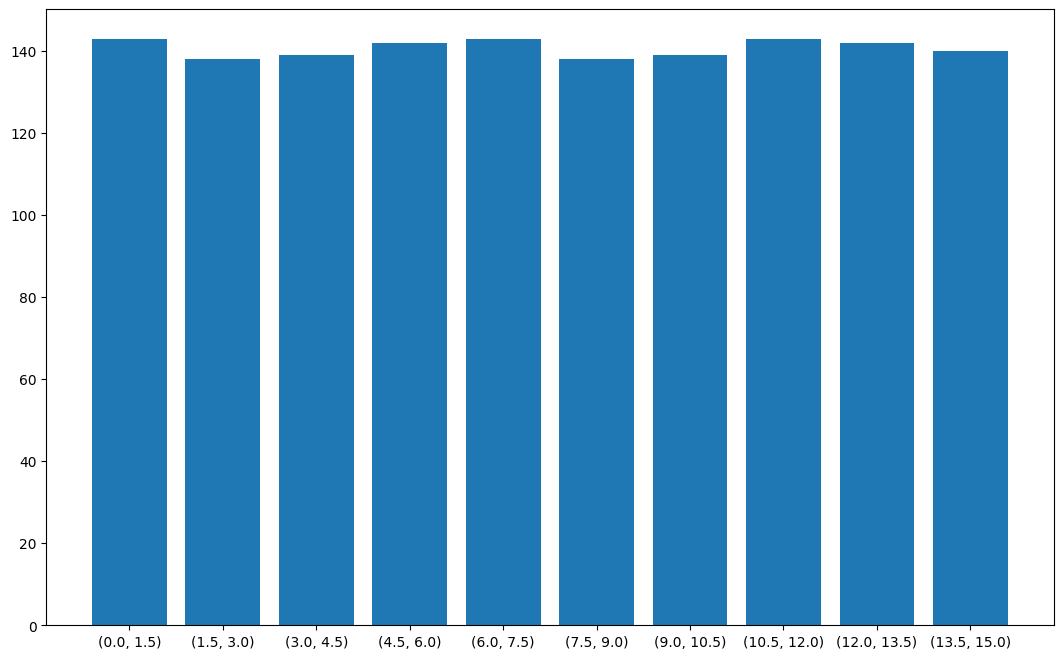

In [533]:
plt.figure(figsize=(13, 8))
plt.bar(df2.iloc[:, 0].astype(str), df2.iloc[:, 1])
plt.show()

In [534]:
df2 = avg_interval(df2)
df2

,xi,ni,avg_interval
0,"(0.0, 1.5)",143,0.75
1,"(1.5, 3.0)",138,2.25
2,"(3.0, 4.5)",139,3.75
3,"(4.5, 6.0)",142,5.25
4,"(6.0, 7.5)",143,6.75
5,"(7.5, 9.0)",138,8.25
6,"(9.0, 10.5)",139,9.75
7,"(10.5, 12.0)",143,11.25
8,"(12.0, 13.5)",142,12.75
9,"(13.5, 15.0)",140,14.25


In [535]:
def get_prob_equal(df):
    def find_probability(row):
        return 1 / df.shape[0] 
        
    df['pi'] = df.apply(find_probability, axis=1)

    return df

In [536]:
print("Гіпотеза H0 - рівномірний закон розподілу")

alpha = float(input(("Введіть рівень значущості: ")))

df2 = get_prob_equal(df2)
df2

Гіпотеза H0 - рівномірний закон розподілу


,xi,ni,avg_interval,pi
0,"(0.0, 1.5)",143,0.75,0.1
1,"(1.5, 3.0)",138,2.25,0.1
2,"(3.0, 4.5)",139,3.75,0.1
3,"(4.5, 6.0)",142,5.25,0.1
4,"(6.0, 7.5)",143,6.75,0.1
5,"(7.5, 9.0)",138,8.25,0.1
6,"(9.0, 10.5)",139,9.75,0.1
7,"(10.5, 12.0)",143,11.25,0.1
8,"(12.0, 13.5)",142,12.75,0.1
9,"(13.5, 15.0)",140,14.25,0.1


In [537]:
df2 = df2.drop('avg_interval', axis=1)

In [538]:
df2 = combine_rows(df2)
df2

,xi,ni,pi
0,"(0.0, 1.5)",143,0.1
1,"(1.5, 3.0)",138,0.1
2,"(3.0, 4.5)",139,0.1
3,"(4.5, 6.0)",142,0.1
4,"(6.0, 7.5)",143,0.1
5,"(7.5, 9.0)",138,0.1
6,"(9.0, 10.5)",139,0.1
7,"(10.5, 12.0)",143,0.1
8,"(12.0, 13.5)",142,0.1
9,"(13.5, 15.0)",140,0.1


In [539]:
x2_emp = get_empirical_x2(df2)
print(f"X2 емпіричне: {x2_emp}")

d_f = df1.shape[0] -1
x2_crit = get_critical_x2(alpha, d_f)
print(f"X2 критичне: {x2_crit}")

if(x2_emp < x2_crit):
    print("Емпіричне < критичне - гіпотезу Н0 приймаємо")
else:
    print("Емпіричне > критичне - гіпотезу Н0 відхиляємо")

X2 емпіричне: 0.2850035536602701
X2 критичне: 8.31117091082631
Емпіричне < критичне - гіпотезу Н0 приймаємо
